# Setup

In [92]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Matrixkit
from matrixkit import preconditioning as precon
from matrixkit.core import MatrixData, ValueProperties, BlockProperties
from matrixkit.block import supervariable_blocking as sv_blocking
from matrixkit.plot import generate_block_matrix as gen_block_mat

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [93]:
MATRIX_DIM = 128
NUMBER_OF_MATRICES = 100
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42

VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

MIN_SV_BLOCK_SIZE = 2  # should not be less than 2
MAX_SV_BLOCK_SIZE = 25  # should not be greater than MATRIX_DIM
BLOCK_SIZE_LIST = [i for i in range(MIN_SV_BLOCK_SIZE, MAX_SV_BLOCK_SIZE + 1)]
NUMBER_OF_DATASETS = MAX_SV_BLOCK_SIZE - MIN_SV_BLOCK_SIZE + 1

To test convergence behaviour dependence on block size, several sets with different average block sizes are generated

In [94]:
# Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(1, 32), size_average=10, size_std_dev=0.66, gap_chance=0.0)

test_data = MatrixData(
    dimension=MATRIX_DIM,
    band_radius=DIAGONAL_BAND_RADIUS,
    sample_size=NUMBER_OF_MATRICES,
    background_noise_value_properties=bgr_noise_value_props,
    block_noise_value_properties=noise_blk_value_props,
    block_noise_block_properties=noise_blk_block_props,
    block_data_value_properties=tdata_blk_value_props,
    block_data_block_properties=tdata_blk_block_props,
    seed=42,
    determinant_cutoff=0.0001,
    print_debug=False
)

matrix_shifted = precon.prepare_matrix(test_data.matrices, 'shift')

Predict blocks using supervariable blocking

In [95]:
list_of_sv_predictions = []
list_of_preconditioner = []

print("".join([f"{i:d}" for i in test_data.tdata_blk_starts[0]]))
for s in BLOCK_SIZE_LIST:
    predictions = sv_blocking(input_matrices=test_data.matrices, max_block_size=s)
    list_of_sv_predictions.append(predictions)
    preconditioner = precon.generate_block_jacobi_preconditioner(sparse_matrices=test_data.matrices, block_start_indicators=predictions, apply_inverse_minmax_norm=True)
    list_of_preconditioner.append(preconditioner)
    
    print("".join([f"{i:d}" for i in predictions[0]]))

10000000000000100000000000000010000000000000000100000001000000000100000000000100000100000000100000100000100000000000000001000010
00001110110000000110100011110100000001110001010101110101001110111111011001011000000011001111110111110100110110001011001100111000
01000011010101001000011110101000001000110010100101000010011110010010000000001000000001100000100000000010100100010100111000111010
00000010010000000010000000100000000001010001010000100001000110001010010000010000000010001001110011110000110110001010001000000000
00010100110000000000000001000000010000000000101000000011001011011000000100000001001000101000000000011100000100010000000000000001
00000010010000000000000010100000000000110000000101000000001110010010000000001000000001000000100000000000100100000000001000111000
00000000100000110100000010100000000000000000100001000000000001000000000010010010000000000100000010000001000100001000100000000010
0000001000000000000000000000000000000100000100000010000000011000100001000000000000000000100000001

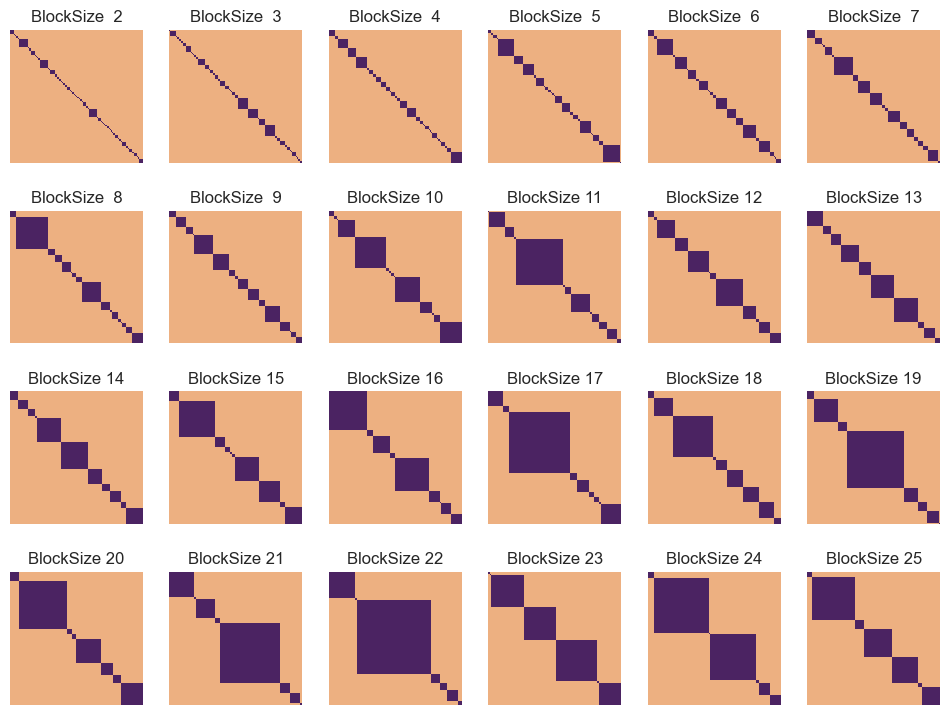

In [108]:
c_map = 'flare'
ctr = 1
for i in range(len(BLOCK_SIZE_LIST)):
    test_fig = plt.figure(num=1, figsize=(12, 9))
    #sp1 = test_fig.add_subplot(24, 4, 2 * ctr - 1)
    #sns.heatmap(preconditioner[0], xticklabels=False, yticklabels=False, cmap=c_map, square=True, vmin=-1, vmax=1)
    #sp2 = test_fig.add_subplot(24, 4, 2 * ctr)
    sp2 = test_fig.add_subplot(4, 6, ctr)
    sp2.set_title(f"BlockSize {BLOCK_SIZE_LIST[i]:2d}")
    sns.heatmap(gen_block_mat(list_of_sv_predictions[i][0]), xticklabels=False, yticklabels=False, cmap=c_map, cbar=False, square=True, vmin=0, vmax=1)
    
    ctr += 1

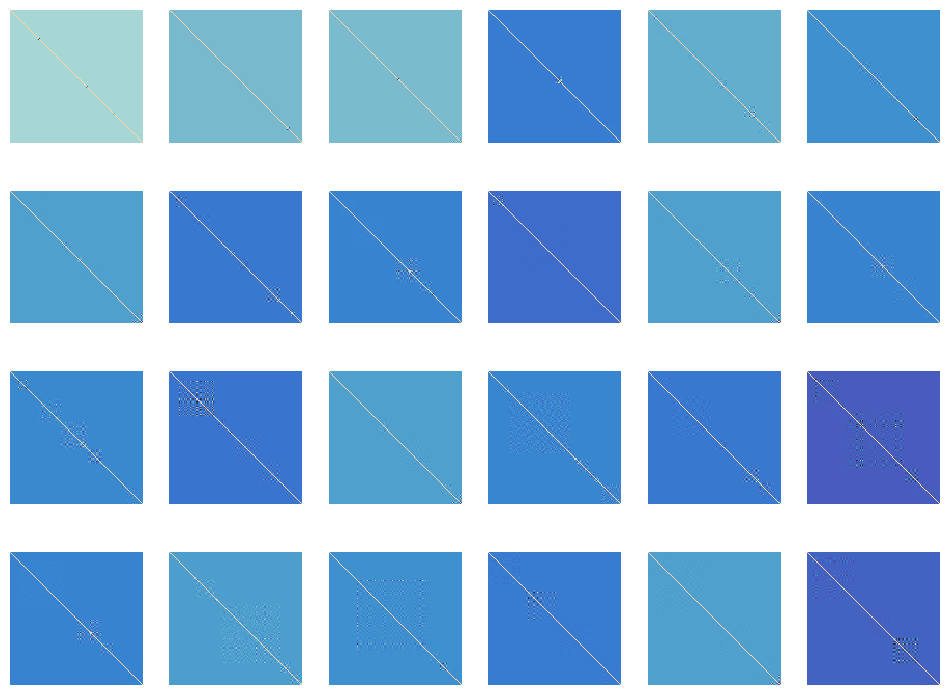

In [112]:
c_map = 'icefire'
ctr = 1
for i in range(len(BLOCK_SIZE_LIST)):
    test_fig = plt.figure(num=1, figsize=(12, 9))
    sp1 = test_fig.add_subplot(4, 6, ctr)
    #sns.heatmap(list_of_preconditioner[i][0], xticklabels=False, yticklabels=False, cmap=c_map, cbar=False, square=True, vmin=-1, vmax=1)
    sns.heatmap(list_of_preconditioner[i][0], xticklabels=False, yticklabels=False, cmap=c_map, cbar=False, square=True)
    
    ctr += 1

In [78]:
list_metadata_shifted = []
list_metadata_original = []

# Generate solution value vector
b = np.ones((NUMBER_OF_MATRICES, MATRIX_DIM))

for i in range(NUMBER_OF_DATASETS):
    print(f"Running GMRES for raw test matrix set [{i:02d}] with preconditioner")
    list_metadata_shifted.append(precon.solve_with_gmres_monitored(matrix=matrix_shifted, b_vector=b, preconditioner=list_of_preconditioner[i]))
    list_metadata_original.append(precon.solve_with_gmres_monitored(matrix=test_data.matrices, b_vector=b, preconditioner=list_of_preconditioner[i]))

Running GMRES for raw test matrix set [00] with preconditioner
(100, 128, 128)

With preconditioner:
--------------------------------------------------------------------------------
  Converged: 3 out of 100
  Average iterations: 24833.62
--------------------------------------------------------------------------------
  iterations: [25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600    15
 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600 25600 25600 25600 25600 25600 25600 25600 25600     8 25600 25600
 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600   139 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600 25600 25600 25600]
(100, 128, 128)


KeyboardInterrupt: 

In [75]:
print("Average iterations to solve for each matrix (shifted)")
for i in range(NUMBER_OF_DATASETS):
    x, info, iters, residuals = list_metadata_shifted[i]
    print(f"Average for iteration {i + 1:2d}: {sum(iters) / len(iters):7.2f}")

Average iterations to solve for each matrix (shifted)
Average for iteration  1:    1.00
Average for iteration  2:    1.00
Average for iteration  3:    1.00
Average for iteration  4:    1.00
Average for iteration  5:    1.00
Average for iteration  6:    1.00
Average for iteration  7:    1.00
Average for iteration  8:    1.00
Average for iteration  9:    1.00
Average for iteration 10:    1.01
Average for iteration 11:    1.00
Average for iteration 12:    1.01
Average for iteration 13:    1.00
Average for iteration 14:    1.00
Average for iteration 15:    1.00
Average for iteration 16:    1.00
Average for iteration 17:    1.00
Average for iteration 18:    1.00
Average for iteration 19:    1.00
Average for iteration 20:    1.01
Average for iteration 21:    1.01
Average for iteration 22:    1.00
Average for iteration 23:    1.00
Average for iteration 24:    1.01


In [76]:
print("Average iterations to solve for each matrix (original")
for i in range(NUMBER_OF_DATASETS):
    x, info, iters, residuals = list_metadata_original[i]
    print(f"Average for iteration {i + 1:2d}: {sum(iters) / len(iters):7.2f}")

Average iterations to solve for each matrix (original
Average for iteration  1:   23.92
Average for iteration  2:   22.48
Average for iteration  3:   26.83
Average for iteration  4:   27.43
Average for iteration  5:   26.97
Average for iteration  6:  325.47
Average for iteration  7:   34.30
Average for iteration  8:   41.27
Average for iteration  9:   28.87
Average for iteration 10:   35.57
Average for iteration 11:   26.26
Average for iteration 12:   27.28
Average for iteration 13:  283.78
Average for iteration 14:   55.23
Average for iteration 15:   75.81
Average for iteration 16:  316.78
Average for iteration 17:   57.89
Average for iteration 18:   45.07
Average for iteration 19:  362.25
Average for iteration 20:  299.85
Average for iteration 21:  108.37
Average for iteration 22:   43.50
Average for iteration 23:   40.16
Average for iteration 24:  318.36
